## One-day-ahead prediction on stock value in USD
$$ Traded Value[m USD] = Traded Volume [m shares] \times Closing Price [USD]$$
<br>
<br>
Given the limited time to spend on this project, I would decompose the question into: <br> 
1) predicting trading volume, and
<br>
2) predicting stock closing price
<br>
although there are an abundance of literatures suggesting relationships between price/return and trading volume.
<br>


## I. Predicting Stock closing price
###  1. Load the data

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
stocks = pd.read_csv('stock.csv')
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks['Date'] = stocks['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
stocks.head()

,Date,ID,Volume,Spread,Volatility,Price,Sentiment
0,2012-02-01,IROSROA,518.195133,0.001272,0.118802,1125.148876,-1.734483
1,2012-02-01,LBQCYGN,782.416185,0.001976,0.141883,14.873362,0.243940
2,2012-02-01,GZMNIJI,792.203352,0.002029,0.144689,15.577075,0.111437
3,2012-02-01,PREGXXP,794.471386,0.001169,0.111836,724.542317,-0.080213
4,2012-02-01,TJXKVVW,660.684739,0.002092,0.152536,12.515318,0.621398


In [2]:
fx = pd.read_csv('fx.csv')
fx.head()

,Date,US/UK,JP/US
0,2012-01-02,1.5537,76.98
1,2012-01-03,1.5655,76.67
2,2012-01-04,1.5638,76.68
3,2012-01-05,1.5480,77.18
4,2012-01-06,1.5431,77.06


In [3]:
classification = pd.read_csv('classification.csv')
classification.head()

,ID,Country
0,IROSROA,JP
1,LBQCYGN,US
2,GZMNIJI,US
3,PREGXXP,JP
4,TJXKVVW,UK


In [4]:
stocks = stocks.merge(classification, how = 'left')
stocks = stocks.merge(fx, how = 'left', on = 'Date')

#### on FX rate
I avoided decomposing **closing price in USD** into **closing price in local currency** and **FX rate against USD** as this would be another element to make predictions on. Although there are studies done on FX rate forecast based on historical FX rates alone using statistical and ML models, since I am not provided with macro economics data and given the time limit, I decided to convert all prices into USD using the historical FX rates provided and make the stock price prediction in USD directly. 

In [5]:
stocks['Price USD'] = np.where(stocks['Country'] == 'JP', stocks['Price']/stocks['JP/US'], 
                              np.where(stocks['Country'] == 'UK', stocks['Price'] * stocks['US/UK'], stocks['Price']))
stocks.head()

,Date,ID,Volume,Spread,Volatility,Price,Sentiment,Country,US/UK,JP/US,Price USD
0,2012-02-01,IROSROA,518.195133,0.001272,0.118802,1125.148876,-1.734483,JP,1.5849,76.11,14.783194
1,2012-02-01,LBQCYGN,782.416185,0.001976,0.141883,14.873362,0.243940,US,1.5849,76.11,14.873362
2,2012-02-01,GZMNIJI,792.203352,0.002029,0.144689,15.577075,0.111437,US,1.5849,76.11,15.577075
3,2012-02-01,PREGXXP,794.471386,0.001169,0.111836,724.542317,-0.080213,JP,1.5849,76.11,9.519673
4,2012-02-01,TJXKVVW,660.684739,0.002092,0.152536,12.515318,0.621398,UK,1.5849,76.11,19.835527


###  2. LSTM models & Model training
#### 2.1 Standard LSTM
<br>
I originally considered using Auto-Regressive Integrated Moving Average (ARIMA) given it's (probably) a non-stationary time series we are working with. However, multiple publications suggested that LSTM provides superior performance to ARIMA in stock market predictions [1][2].
<br>
I explore the results with randomly one US stock and one non-US stock.

In [57]:
ticker = 'LBQCYGN' # I start by taking the first US stock as an example

df = stocks[stocks['ID'] == ticker][['Date','Price USD','Sentiment']].set_index('Date')
df.fillna(method = 'ffill', inplace = True) #in case there's no price, fill with previous day close
df.head()

,Price USD,Sentiment
Date,,
2012-02-01,14.873362,0.243940
2012-03-01,15.163614,-0.130350
2012-04-01,15.098638,0.178536
2012-05-01,14.912976,0.543603
2012-06-01,14.962083,0.447191


In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1)) 
px_norm = scaler.fit_transform(df['Price USD'].values.reshape(-1,1))

In [59]:
def df_to_XY(px_norm, window_size=5):#test 5, 10, 15, 20, 30
    X = []
    Y = []
    for i in range(len(px_norm)-window_size):
        X.append([pair for pair in px_norm[i:i+window_size]])
        Y.append(px_norm[i+window_size, 0])
    return np.array(X), np.array(Y)

In [87]:
window_size = 10
X0, Y0 = df_to_XY(px_norm, WINDOW_SIZE)
X0.shape, Y0.shape

((1816, 10, 1), (1816,))

In [66]:
def split_data(X, Y, train_split = 0.8): #default train/test split is 80/20

    split_index = int(Y.shape[0] * train_split)
    
    X_train, Y_train = X[:split_index], Y[:split_index]
    X_test, Y_test = X[split_index:], Y[split_index:]
    
    return X_train, Y_train, X_test, Y_test, split_index

In [67]:
X0_train, Y0_train, X0_test, Y0_test, split_index = split_data(X0, Y0)
X0_train.shape, Y0_train.shape, X0_test.shape, Y0_test.shape

((1452, 10, 1), (1452,), (364, 10, 1), (364,))

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

3 parameters need to be decided:
1) # of layers <br>
2) # unit <br>
3) dropout %

<br>
The optimal parameters should be obtained by comparing the deviation of the predicted results. 
In this model, I will set 1 input layer,  3 LSTM layers, each followed by a dropout layer, and a final dense layer as ouput.
<br>
I will set the unit number for each LSTM layer to be 100 and the dropout rate to be 0.1.

In [64]:
model0 = Sequential()
model0.add(LSTM(units=100,return_sequences=True,input_shape=(WINDOW_SIZE, 1)))
model0.add(LSTM(units=100,return_sequences=True))
model0.add(Dropout(0.1))
model0.add(LSTM(units=100,return_sequences=True))
model0.add(Dropout(0.1))
model0.add(LSTM(units=100))
model0.add(Dropout(0.1))
model0.add(Dense(units=1))

model0.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
model0.fit(X0_train,Y0_train, epochs=10) #batch size?

Epoch 1/10
46/46 [==============================] - 11s 128ms/step - loss: 0.0401
Epoch 2/10
46/46 [==============================] - 6s 127ms/step - loss: 0.0069
Epoch 3/10
46/46 [==============================] - 6s 125ms/step - loss: 0.0066
Epoch 4/10
46/46 [==============================] - 6s 122ms/step - loss: 0.0065
Epoch 5/10
46/46 [==============================] - 6s 124ms/step - loss: 0.0063
Epoch 6/10
46/46 [==============================] - 6s 125ms/step - loss: 0.0064
Epoch 7/10
46/46 [==============================] - 6s 127ms/step - loss: 0.0065
Epoch 8/10
46/46 [==============================] - 6s 131ms/step - loss: 0.0061
Epoch 9/10
46/46 [==============================] - 6s 126ms/step - loss: 0.0063
Epoch 10/10
46/46 [==============================] - 6s 124ms/step - loss: 0.0054


12/12 [==============================] - 0s 21ms/step


([<matplotlib.axis.XTick at 0x1f0f43ae160>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

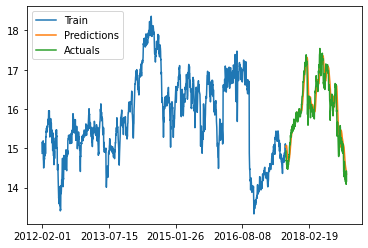

In [133]:
test_predictions0 = model0.predict(X0_test)
px_predict0 = scaler.inverse_transform(test_predictions0)
results0 = pd.DataFrame(data={'Test Predictions':px_predict0.flatten(), 
                              'Actuals':df.iloc[split_index+window_size:]['Price USD']})

import matplotlib.pyplot as plt
plt.plot(df.iloc[:split_index+window_size]['Price USD'])
plt.plot(results0[['Test Predictions', 'Actuals']])
plt.legend(['Train', 'Predictions', 'Actuals'], loc='upper left')
plt.xticks(np.arange(0, X0.shape[0], 400))

In [22]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape


def performance_measure(model, X, y, method = 'Standard LSTM'):
    predictions = model.predict(X).flatten()
    return pd.DataFrame({'MSE': mse(y, predictions), 
                         'MAE': mae(y, predictions), 
                         'MAPE': mape(y, predictions), 
                         'Accuracy': 1-mape(y, predictions)}, index = [method])

In [23]:
res0 = performance_measure(model0, X0_test, Y0_test.flatten())
res0

12/12 [==============================] - 0s 11ms/step


,MSE,MAE,MAPE,Accuracy
Standard LSTM,0.004804,0.054774,0.120238,0.879762


#### 2.2 LSTM with historical data and sentiment score pair
<br>
Intuitively it makes sense that **sentiment score** affect the stock price, and various research discusses the importance of incorporating sentiment in stock market predictions [3][4].
<br>
I will first explore the method used in "Stock price prediction using news sentiment analysis" by S. Mohan et al. [5] where the historical price and sentiment score are paired to for price prediction by LSTM. The pairs are 
$(Price_{t-1}, Sentiment Score_{t}),...,(Price_{t-m}, Sentiment Score_{t-m-1})$

In [24]:
sent_norm =  scaler.fit_transform(df['Sentiment'].values.reshape(-1,1)) # we also normalize the sentiment scores

In [25]:
df_norm = np.hstack((px_norm[1:], sent_norm[:-1])) # because we are pairing price with sentiment score with 1 step offset
df_norm.shape

(1825, 2)

In [26]:
#WINDOW_SIZE = 5
X1, Y1 = df_to_XY(df_norm, WINDOW_SIZE)
X_train1, Y_train1, X_test1, Y_test1 = split_data(X1, Y1)
X_train1.shape, Y_train1.shape, X_test1.shape, Y_test1.shape

((1452, 10, 2), (1452,), (363, 10, 2), (363,))

In [28]:
model1 = Sequential()
model1.add(LSTM(units=100,return_sequences=True,input_shape=(WINDOW_SIZE, 2))) # we use the same model except input shape is nx2 
model1.add(LSTM(units=100,return_sequences=True))
model1.add(Dropout(0.1))
model1.add(LSTM(units=100,return_sequences=True))
model1.add(Dropout(0.1))
model1.add(LSTM(units=100))
model1.add(Dropout(0.1))
model1.add(Dense(units=1))


model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
model1.fit(X_train1,Y_train1, epochs=10)

Epoch 1/10
46/46 [==============================] - 7s 37ms/step - loss: 0.0357
Epoch 2/10
46/46 [==============================] - 2s 36ms/step - loss: 0.0068
Epoch 3/10
46/46 [==============================] - 2s 38ms/step - loss: 0.0069
Epoch 4/10
46/46 [==============================] - 2s 35ms/step - loss: 0.0064
Epoch 5/10
46/46 [==============================] - 2s 37ms/step - loss: 0.0064
Epoch 6/10
46/46 [==============================] - 2s 35ms/step - loss: 0.0061
Epoch 7/10
46/46 [==============================] - 2s 35ms/step - loss: 0.0063
Epoch 8/10
46/46 [==============================] - 2s 35ms/step - loss: 0.0056
Epoch 9/10
46/46 [==============================] - 2s 35ms/step - loss: 0.0053
Epoch 10/10
46/46 [==============================] - 2s 35ms/step - loss: 0.0056


In [32]:
res1 = performance_measure(model1, X_test1, Y_test1.flatten(), 'Pair LSTM')
res1

12/12 [==============================] - 0s 13ms/step


,MSE,MAE,MAPE,Accuracy
Pair LSTM,0.004875,0.058049,0.113555,0.886445


#### 2.3 LSTM with historical data and sentiment score as additional row
<br>
Another way to incorporate sentiment score into the LSTM model mentioned in "FinBERT-LSTM: Deep Learning based stock price prediction using News Sentiment Analysis" by S. Halder [4] is to combine the closing stock price of 10 days and news sentiment on that day, resulting in the input layer shape to be 11 x 1.
<br>
I replicate the method below with rolling window size default to be 5.

In [33]:
def df_to_XY_add_sent(px_norm, sent_norm, window_size=5):#test 5, 10, 15, 20, 30
    X = []
    Y = []
    for i in range(len(px_norm)-window_size):
        X.append(np.concatenate((px_norm[i:i+window_size], sent_norm[i+window_size-1:i+window_size]), axis = 0))
        Y.append(px_norm[i+window_size, 0])
    return np.array(X), np.array(Y)

In [34]:
#WINDOW_SIZE = 5
X2, Y2 = df_to_XY_add_sent(px_norm, sent_norm, WINDOW_SIZE)
X2.shape, Y2.shape

((1816, 11, 1), (1816,))

In [35]:
X_train2, Y_train2, X_test2, Y_test2 = split_data(X2, Y2)
X_train2.shape, Y_train2.shape, X_test2.shape, Y_test2.shape

((1452, 11, 1), (1452,), (364, 11, 1), (364,))

In [36]:
model2 = Sequential()
model2.add(LSTM(units=100,return_sequences=True,input_shape=(WINDOW_SIZE+1, 1))) # we use the same model except input shape is (n+1)x1
model2.add(LSTM(units=100,return_sequences=True))
model2.add(Dropout(0.1))
model2.add(LSTM(units=100,return_sequences=True))
model2.add(Dropout(0.1))
model2.add(LSTM(units=100))
model2.add(Dropout(0.1))
model2.add(Dense(units=1))


model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
model2.fit(X_train2,Y_train2, epochs=10)

Epoch 1/10
46/46 [==============================] - 8s 37ms/step - loss: 0.0341
Epoch 2/10
46/46 [==============================] - 2s 37ms/step - loss: 0.0062
Epoch 3/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0059
Epoch 4/10
46/46 [==============================] - 2s 40ms/step - loss: 0.0058
Epoch 5/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0059
Epoch 6/10
46/46 [==============================] - 2s 42ms/step - loss: 0.0056
Epoch 7/10
46/46 [==============================] - 2s 43ms/step - loss: 0.0051
Epoch 8/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0052
Epoch 9/10
46/46 [==============================] - 2s 39ms/step - loss: 0.0050
Epoch 10/10
46/46 [==============================] - 2s 45ms/step - loss: 0.0049


In [115]:
res2 = performance_measure(model2, X_test2, Y_test2.flatten(), 'Pair LSTM')
res2

12/12 [==============================] - 0s 24ms/step


,MSE,MAE,MAPE,Accuracy
Pair LSTM,0.002835,0.042233,0.090603,0.909397


I combine the 3 performance measure tables. <br>
I can see that the Additional feature LSTM way of incorporating sentiment score performed better for this specific stock. 

In [116]:
summary = pd.concat([res0, res1, res2], axis = 0)
summary

,MSE,MAE,MAPE,Accuracy
Standard LSTM,0.004804,0.054774,0.120238,0.879762
Pair LSTM,0.004875,0.058049,0.113555,0.886445
Pair LSTM,0.002835,0.042233,0.090603,0.909397


###  3. Performance
I now put these code into functions and test on a few more stocks.

In [209]:
import toolkit as tk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# ticker = 'LBQCYGN' #US stock
# df = tk.load_data(ticker)
# summary = tk.compare(tk.standard_LSTM(df), 
#                      tk.LSTM_pair(df, method = 'LSTM Pair'),
#                      tk.LSTM_addl_feature(df, method = 'LSTM Addl feature'))
# summary

In [44]:
ticker = 'IROSROA' #JP sotck
df = tk.load_data(ticker)
summary = tk.compare(tk.standard_LSTM(df), 
                     tk.LSTM_pair(df, method = 'LSTM Pair'),
                     tk.LSTM_addl_feature(df, method = 'LSTM Addl feature'))
summary

12/12 [==============================] - 1s 10ms/step


,MSE,MAE,MAPE,Accuracy
Standard LSTM,0.004624,0.052130,0.238219,0.761781
LSTM Pair,0.011367,0.089350,0.313555,0.686445
LSTM Addl feature,0.006711,0.066567,0.201296,0.798704


In [45]:
ticker = 'TJXKVVW' #UK Stock

df = tk.load_data(ticker)
summary = tk.compare(tk.standard_LSTM(df), 
                     tk.LSTM_pair(df, method = 'LSTM Pair'),
                     tk.LSTM_addl_feature(df, method = 'LSTM Addl feature'))
summary

12/12 [==============================] - 1s 14ms/step


,MSE,MAE,MAPE,Accuracy
Standard LSTM,0.010806,0.087206,0.176049,0.823951
LSTM Pair,0.008811,0.076546,0.179311,0.820689
LSTM Addl feature,0.007389,0.069147,0.160596,0.839404


In [46]:
ticker = 'GZMNIJI' #US stock 

df = tk.load_data(ticker)
summary = tk.compare(tk.standard_LSTM(df), 
                     tk.LSTM_pair(df, method = 'LSTM Pair'),
                     tk.LSTM_addl_feature(df, method = 'LSTM Addl feature'))
summary

12/12 [==============================] - 1s 17ms/step


,MSE,MAE,MAPE,Accuracy
Standard LSTM,0.002418,0.036514,0.085478,0.914522
LSTM Pair,0.001790,0.033847,0.073085,0.926915
LSTM Addl feature,0.001537,0.029513,0.066532,0.933468


In [47]:
ticker = 'PREGXXP' #JP stock

df = tk.load_data(ticker)
summary = tk.compare(tk.standard_LSTM(df), 
                     tk.LSTM_pair(df, method = 'LSTM Pair'),
                     tk.LSTM_addl_feature(df, method = 'LSTM Addl feature'))
summary

12/12 [==============================] - 1s 17ms/step


,MSE,MAE,MAPE,Accuracy
Standard LSTM,0.004440,0.050003,0.099776,0.900224
LSTM Pair,0.007186,0.069739,0.126724,0.873276
LSTM Addl feature,0.003836,0.045507,0.093168,0.906832


In [48]:
ticker = 'GNDARTH' #UK stock

df = tk.load_data(ticker)
summary = tk.compare(tk.standard_LSTM(df), 
                     tk.LSTM_pair(df, method = 'LSTM Pair'),
                     tk.LSTM_addl_feature(df, method = 'LSTM Addl feature'))
summary

12/12 [==============================] - 1s 14ms/step


,MSE,MAE,MAPE,Accuracy
Standard LSTM,0.007984,0.073273,0.104526,0.895474
LSTM Pair,0.005544,0.057454,0.087639,0.912361
LSTM Addl feature,0.005100,0.054319,0.085520,0.914480


From the above, we can see that for the two US stock examples, LSTM Additional Feature model has a 24.65% and 22.16% MAPE and 2.96% and 1.89% accuracy performance improvement over the standard LSTM model. The LSTM Pair model also provides performance improvements over the standard LSTM model.
<br>
While for the non-US stock examples, the LSTM Additional Feature model still provides the improved performance over the standard LSTM mode, this is not always the case for LSTM Pair model. 
<br>
<br>
###  4. Stock price predictions
Given the above, I will use the **LSTM Additional Feature model** to predict the one-day-ahead stock price for the 100 stocks.

In [172]:
stock_list = list(stocks['ID'].unique())

In [217]:
# ticker = stock_list[10]
ticker = 'HQFUPUK'
df = tk.load_data(ticker)

In [218]:
df.head(3)

,Date,Price USD,Sentiment
6,2012-02-01,9.284709,0.089430
106,2012-03-01,9.595690,-0.011933
206,2012-04-01,9.538023,0.364095


In [251]:
%load_ext autoreload
%autoreload 2
res_list = tk.predict_LSTM_af(df, 10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
12/12 [==============================] - 0s 12ms/step


In [252]:
res_list

[11.156252, 0.9589124546501068]

In [179]:
def normalize(data):
    """
    Takes a Series and normalize it.
    """
    scaler = MinMaxScaler(feature_range=(0,1)) 
    norm_series = scaler.fit_transform(data.values.reshape(-1,1))
    return norm_series

In [182]:
def split_data(X, Y, train_split = 0.8): #default train/test split is 80/20

    split_index = int(Y.shape[0] * train_split)
    
    X_train, Y_train = X[:split_index], Y[:split_index]
    X_test, Y_test = X[split_index:], Y[split_index:]
    
    return X_train, Y_train, X_test, Y_test,

In [190]:
def df_to_XY_add_sent(px_norm, sent_norm, window_size=5):
    X = []
    Y = []
    for i in range(len(px_norm)-window_size):
        X.append(np.concatenate((px_norm[i:i+window_size], sent_norm[i+window_size-1:i+window_size]), axis = 0))
        Y.append(px_norm[i+window_size, 0])
    return np.array(X), np.array(Y)

In [249]:
accuracy[0]

0.9578828332469338

12/12 [==============================] - 0s 11ms/step


In [244]:
oneday_predict_px

array([[11.198192]], dtype=float32)

## REFERENCES

[1] Khalid Bin Saboor, Qurat Ul Ain Saboor, Liyan Han, Abdul Saboor Zahid. "Predicting the Stock Market using Machine Learning: Long short-term Memory". *Electronic Research Journal of Engineering, Computer and Applied Sciences* Volume 2 (2020). Available from: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3810128 <br>

[2] Ruochen Xiao, Yingying Feng, Lei Yan, Yihan Ma. "Predict Stock Prices with ARIMA and LSTM". *arXiv*:2209.02407v1 [q-fin.ST] 31 Aug 2022. Available from: https://arxiv.org/pdf/2209.02407.pdf <br>

[3] Shilpa Gite, Hrituja Khatavkar1, Ketan Kotecha, Shilpi Srivastava, Priyam Maheshwari Neerav Pandey. "Explainable stock prices prediction from financial news articles using sentiment analysis". *PeerJ Computer Science* Published 28 January 2021. Available from: https://www.semanticscholar.org/paper/Explainable-stock-prices-prediction-from-financial-Gite-Khatavkar/25a07bf9755fbfc73b11668517b8a6f54c362e4c <br>

[4] Halder Shayan. "FinBERT-LSTM: Deep Learning based on stock price prediction using News Sentiment Analysis". *arXiv*:2211.07392v1 [q-fin.ST] 11 Nov 2022. Avaialble from: https://arxiv.org/pdf/2211.07392.pdf <br>

[5] S. Mohan, S. Mullapudi, S. Sammeta, P. Vijayvergia and D.C. Anastasiu. "Stock price prediction using news sentiment analysis". *2019 IEEE Fifth International Conference on Big Data Computing Service and Applications*, IEEE, 2019, pp.205-208